In [1]:
import os
import re
from pathlib import Path
from math import radians, sin, cos, atan2, sqrt

import pandas as pd
import numpy as np
import folium
import branca
import gdown
from scipy.spatial import distance
from geopy.distance import geodesic

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic, pacf, acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import dash
from dash import dcc, html
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Carga de datos de contaminantes del mes de Enero de 2024

Cargamos tanto los datos de contaminantes en diferentes estaciones como información de los diferentes puntos de medición

In [2]:
contaminante = 8

In [3]:
contaminacion_mes_madrid = pd.read_csv('https://www.dropbox.com/scl/fi/jciybhaty3mps5kfikra6/ene_mo24.csv?rlkey=jgelc5op7v0hbuosfk7lei956&st=0rukefww&dl=1',sep=';')
estaciones_df = pd.read_excel('https://www.dropbox.com/scl/fi/3mfaz79uow6pqud3j19vc/informacion_estaciones_red_calidad_aire.xls?rlkey=h1uaefe0mt87u7d0yvdneidg3&st=ihyekq04&dl=1')

In [4]:
estaciones_df

,CODIGO,CODIGO_CORTO,ESTACION,DIRECCION,LONGITUD_ETRS89,LATITUD_ETRS89,ALTITUD,COD_TIPO,NOM_TIPO,NO2,...,BTX,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,Fecha alta,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89,LONGITUD,LATITUD
0,28079004,4,Plaza de España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637,UT,Urbana tráfico,X,...,NaN,273600,PLAZA,DE,ESPAÑA,1998-12-01,439579.329073,4.475049e+06,-3.712257,40.423882
1,28079008,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,"3°40'56.22""O","40°25'17.63""N",672,UT,Urbana tráfico,X,...,X,18900,CALLE,DE,ALCALA,1998-12-01,442117.236578,4.474771e+06,-3.682316,40.421553
2,28079011,11,Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,"3°40'38.50""O","40°27'5.29""N",709,UT,Urbana tráfico,X,...,X,610450,CALLE,DEL,PRINCIPE DE VERGARA,1998-12-01,442564.045713,4.478089e+06,-3.677349,40.451473
3,28079016,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3°38'21.17""O","40°26'24.20""N",695,UF,Urbana fondo,X,...,NaN,798700,CALLE,DEL,VIZCONDE DE LOS ASILOS,1998-12-01,445786.172865,4.476796e+06,-3.639242,40.440046
4,28079017,17,Villaverde,C/ Juan Peñalver,"3°42'47.89""O","40°20'49.74""N",601,UF,Urbana fondo,X,...,NaN,417200,CALLE,DE,JUAN PEÑALVER,1998-12-01,439420.701532,4.466532e+06,-3.713317,40.347147
5,28079018,18,Farolillo,C/ Farolillo - C/ Ervigio,"3°43'54.61""O","40°23'41.22""N",625,UF,Urbana fondo,X,...,X,1903,CALLE,DEL,FAROLILLO,2001-03-31,437891.696120,4.471833e+06,-3.731836,40.394782
6,28079024,24,Casa de Campo,Casa de Campo (Terminal del Teleférico),"3°44'50.44""O","40°25'9.69""N",645,S,Suburbana,X,...,NaN,905219,CARRETERA,DEL,TELEFERICO,1998-12-01,436598.563744,4.474572e+06,-3.747345,40.419358
7,28079027,27,Barajas Pueblo,"C/ Júpiter, 21","3°34'48.10""O","40°28'36.93""N",619,UF,Urbana fondo,X,...,NaN,425700,CALLE,DE,JUPITER,2002-12-31,450835.202581,4.480854e+06,-3.580026,40.476918
8,28079035,35,Plaza del Carmen,Plaza del Carmen esq. Tres Cruces,"3°42'11.40""O","40°25'9.15""N",660,UF,Urbana fondo,X,...,NaN,145800,PLAZA,DEL,CARMEN,1999-11-01,440346.361892,4.474524e+06,-3.703166,40.419209
9,28079036,36,Moratalaz,Avda. Moratalaz esq. Camino de los Vinateros,"3°38'43.02""O","40°24'28.64""N",671,UT,Urbana tráfico,X,...,NaN,522000,AVENIDA,DE,MORATALAZ,1998-12-01,445245.513003,4.473237e+06,-3.645310,40.407952


Nos quedamos con las mediciones de NO2  

In [5]:
contaminacion_mes_madrid = contaminacion_mes_madrid[contaminacion_mes_madrid['MAGNITUD'] == contaminante]
contaminacion_mes_madrid

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
62,28,79,4,8,28079004_8_8,2024,1,1,15.0,V,...,63.0,V,58.0,V,61.0,V,59.0,V,55.0,V
63,28,79,4,8,28079004_8_8,2024,1,2,41.0,V,...,60.0,V,53.0,V,49.0,V,48.0,V,54.0,V
64,28,79,4,8,28079004_8_8,2024,1,3,45.0,V,...,38.0,V,43.0,V,43.0,V,39.0,V,51.0,V
65,28,79,4,8,28079004_8_8,2024,1,4,51.0,V,...,51.0,V,48.0,V,36.0,V,25.0,V,20.0,V
66,28,79,4,8,28079004_8_8,2024,1,5,19.0,V,...,32.0,V,25.0,V,20.0,V,14.0,V,8.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,28,79,60,8,28079060_8_8,2024,1,27,55.0,V,...,50.0,V,54.0,V,65.0,V,56.0,V,55.0,V
3877,28,79,60,8,28079060_8_8,2024,1,28,46.0,V,...,67.0,V,73.0,V,80.0,V,67.0,V,65.0,V
3878,28,79,60,8,28079060_8_8,2024,1,29,41.0,V,...,66.0,V,61.0,V,66.0,V,61.0,V,51.0,V
3879,28,79,60,8,28079060_8_8,2024,1,30,55.0,V,...,78.0,V,76.0,V,76.0,V,76.0,V,78.0,V


Nos vamos a quedar sólo con las estaciones que aparecen en las mediciones del mes de enero de 2024

In [6]:
estaciones = contaminacion_mes_madrid['ESTACION'].unique()

In [7]:
estaciones_df = estaciones_df[estaciones_df['CODIGO_CORTO'].isin(estaciones)]

## Representación en un mapa de las estaciones de medición

In [8]:
def dms_to_decimal(dms_str):
    """
    Convierte cualquier cosa como:
      "3º 40' 57''O", "3°40'57.00\"O", "40° 25' 25.98\"N", etc.
    a decimal (- para S/O).
    """
    s = dms_str.strip()
    hemi = s[-1].upper()
    dms_part = s[:-1]
    # Extrae todas las piezas numéricas (grados, minutos, segundos)
    nums = re.findall(r"[\d\.]+", dms_part)
    if len(nums) != 3:
        raise ValueError(f"Formato inesperado (esperaba 3 números): {dms_str!r}")
    deg, minute, sec = map(float, nums)
    dd = deg + minute/60 + sec/3600
    if hemi in ('S', 'O'):  # Sur y Oeste negativos
        dd = -dd
    return dd


In [9]:
estaciones_df['lon_dd'] = estaciones_df['LONGITUD_ETRS89'].apply(dms_to_decimal)
estaciones_df['lat_dd'] = estaciones_df['LATITUD_ETRS89'].apply(dms_to_decimal)

In [10]:
centro = [ estaciones_df['lat_dd'].mean(), estaciones_df['lon_dd'].mean() ]

m = folium.Map(location=centro, zoom_start=13)

# 2) Añadir marcadores
for _, row in estaciones_df.iterrows():
    folium.Marker(
        location=[row['lat_dd'], row['lon_dd']],
        popup=row['ESTACION']
    ).add_to(m)
display(m)

Como el objetivo de este trabajo es el estudio de la relación entre la intensidad del tráfico y la concentración de NO2. Vamos a eliminar del conjunto de datos las estaciones que podrían ser outliers, es decir las estaciones situadas dentro de parques (Casa de Campo, El Retiro, Juan Carlos I y  El Pardo) así como la estación de Barajas.

In [11]:
estaciones_eliminar = ['Barajas Pueblo', 'Casa de Campo', 'El Pardo', 'Parque del Retiro', 'Juan Carlos I']
estaciones_df = estaciones_df[~estaciones_df['ESTACION'].isin(estaciones_eliminar)]


## Preprocesamiento de datos

A continuación llevaremos a cabo el preprocesamiento de los datos de contaminación. Actualmente estamos trabajando con un mes de datos, por lo que crearemos una función para posteriormente poder reutilizar este procesamiento en el resto de meses.

Los datos originales tienen una frecuencia diaria, y cada fila representa las mediciones de un contaminante en una estación concreta a lo largo de un dia. Por tanto el procesamiento consistirá en:

* Filtrar para quedarnos sólo con las mediciones de las estaciones que nos interesan y del contaminante de estudio NO2
* Modificar la frecuencia para que pase a ser horaria en lugar de diaria

In [12]:
def procesar_serie_horaria(df, contaminante, estaciones):
    """
    Convierte un DataFrame mensual de contaminación (con columnas H01–H24 y V01–V24)
    en una serie horaria indexada por datetime, filtrando por magnitud y estaciones.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene, al menos, las columnas:
        ['MAGNITUD','ESTACION','ANO','MES','DIA','H01'…'H24','V01'…'V24']
    contaminante : int o str
        Valor de la columna MAGNITUD a filtrar (p.ej. 8).
    estaciones : list
        Lista de códigos de estación a conservar (valores de la columna ESTACION).

    Devuelve:
    ---------
    pd.DataFrame con índice datetime y columnas:
        ['ESTACION','medicion','flag']
    """
    # 1) Filtrar por magnitud y por estaciones
    df_f = df[
        (df['MAGNITUD'] == contaminante) &
        (df['ESTACION'].isin(estaciones))
    ].copy()
    if df_f.empty:
        return pd.DataFrame(
            columns=['ESTACION','medicion','flag'],
            index=pd.DatetimeIndex([], name='fecha_hora')
        )

    # 2) Desplegar H01–H24 y V01–V24 en formato “long”
    df_long = pd.wide_to_long(
        df_f,
        stubnames=['H','V'],
        i=['ANO','MES','DIA','ESTACION'],
        j='hora',
        sep='',             # porque las columnas son H01, H02, …
        suffix='\\d+'       # para capturar el número de hora
    ).reset_index()

    # 3) Renombrar columnas de valor y flag
    df_long = df_long.rename(columns={'H':'medicion','V':'flag'})

    # 4) Construir la columna datetime correctamente
    fecha_base = pd.to_datetime({
        'year':  df_long['ANO'],
        'month': df_long['MES'],
        'day':   df_long['DIA'],
    })
    # sumamos la 'hora' (1–24); si hora==24 → añade 24h → pasa al día siguiente 00:00
    df_long['fecha_hora'] = fecha_base + pd.to_timedelta(df_long['hora'], unit='h')

    # 5) Seleccionar y ordenar, poniendo fecha_hora como índice
    resultado = (
        df_long.loc[:, ['ESTACION','fecha_hora','medicion','flag']]
               .set_index('fecha_hora')
               .sort_index()
    )

    return resultado


In [13]:
contaminacion_mes_madrid = procesar_serie_horaria(contaminacion_mes_madrid,
                               contaminante,
                               estaciones)
contaminacion_mes_madrid.head(10)

,ESTACION,medicion,flag
fecha_hora,,,
2024-01-01 01:00:00,4,15.0,V
2024-01-01 01:00:00,58,12.0,V
2024-01-01 01:00:00,57,31.0,V
2024-01-01 01:00:00,8,22.0,V
2024-01-01 01:00:00,56,32.0,V
2024-01-01 01:00:00,55,38.0,V
2024-01-01 01:00:00,54,44.0,V
2024-01-01 01:00:00,50,28.0,V
2024-01-01 01:00:00,11,23.0,V


In [14]:
contaminacion_mes_madrid.rename(columns={'ESTACION':'CODIGO_CORTO'}, inplace=True)

# Cargando datos del tráfico del mes de Enero 2024

A continuación vamos a cargar los datos de tráfico medidos cada 15 minutos en diferentes estaciones de Madrid, y los metadatos asociados a estos detectores del tráfico

In [15]:
trafico_mes_madrid = pd.read_csv('https://www.dropbox.com/scl/fi/x05ygc88oay5ztaawwwvc/01-2024.csv?rlkey=8lfkm3j4lsa6aahwzss0hsvkb&st=upqh55v6&dl=1', sep=';')
trafico_mes_madrid.head(10)

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1001,2024-01-01 00:00:00,C30,300,1.0,0,57.0,N,5
1,1001,2024-01-01 00:15:00,C30,168,0.0,0,62.0,N,5
2,1001,2024-01-01 00:30:00,C30,540,2.0,0,61.0,N,5
3,1001,2024-01-01 00:45:00,C30,1140,3.0,0,64.0,N,5
4,1001,2024-01-01 01:00:00,C30,1920,5.0,0,62.0,N,5
5,1001,2024-01-01 01:15:00,C30,2196,5.0,0,59.0,N,5
6,1001,2024-01-01 01:30:00,C30,2436,7.0,0,61.0,N,5
7,1001,2024-01-01 01:45:00,C30,2892,9.0,0,60.0,N,5
8,1001,2024-01-01 02:00:00,C30,2280,6.0,0,59.0,N,5
9,1001,2024-01-01 02:15:00,C30,1944,7.0,0,57.0,N,5


In [16]:
estaciones_trafico_df = pd.read_csv('https://www.dropbox.com/scl/fi/wy21x3lhb5cajk95ktr9f/pmed_ubicacion_01-2024.csv?rlkey=vtyw0lssw2ltq5uvkdl0hmxzc&st=chw5lnte&dl=1', sep=';')
estaciones_trafico_df.head(10)

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud
0,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502
1,URB,4.0,3841,01002,Jose Ortega y Gasset O-E - Serrano-Pº Castellana,441705.882340,4.475770e+06,-3.687256,40.430524
2,URB,1.0,3842,01003,Pº Recoletos N-S - Almirante-Prim,441319.371258,4.474841e+06,-3.691727,40.422132
3,URB,4.0,3843,01004,Pº Recoletos S-N - Pl. Cibeles- Recoletos,441301.632986,4.474764e+06,-3.691929,40.421433
4,URB,4.0,3844,01005,(AFOROS) Pº Castellana S-N - Eduardo Dato - P...,441605.765072,4.476132e+06,-3.688470,40.433782
5,URB,4.0,3845,01006,Pº Recoletos S-N - Villanueva-Jorge Juan,441382.968851,4.474994e+06,-3.690991,40.423512
6,URB,1.0,3846,01007,Sagasta 20 O-E - Mejia Lequerica-Pl. Alonso Ma...,440758.289091,4.475515e+06,-3.698403,40.428164
7,URB,7.0,3847,01008,Almagro 7 N-S - Zurbano-Pl. Alonso Martinez,441085.139018,4.475582e+06,-3.694556,40.428791
8,URB,7.0,3848,01009,(AFOROS) Genova 13 E-O - Zurbano-Campoamor,441114.888348,4.475375e+06,-3.694187,40.426925
9,URB,1.0,3849,01010,PL. SANTA BARBARA S-N(SERRANO ANGUITA-PL. ALO...,440913.426928,4.475372e+06,-3.696561,40.426881


## Asignación de estaciones de tráfico a las estaciones de contaminación

Lo siguiente que vamos a hacer es para cada punto de medición de NO2 en el aire se le asignarán una serie de puntos de medición de la intesidad del trafico. Para ello, para cada punto de medición de NO2 se definirá un radio de 200 metros, y todos los puntos de medición del trafico que estén dentro de este rango se asignarán a este punto de medición de calidad del aire. Si un punto de medición de calidad del aire dispone de menos de 3 puntos de medición de tráfico en un rango de 200 metros se descartará del análisis

In [17]:
estaciones_trafico = trafico_mes_madrid['id'].unique()
estaciones_trafico_df = estaciones_trafico_df[estaciones_trafico_df['id'].isin(estaciones_trafico)]
estaciones_trafico_df = estaciones_trafico_df[estaciones_trafico_df['tipo_elem'] == 'URB']

In [18]:
import geopandas as gpd
from shapely.geometry import Point

aire_gdf = gpd.GeoDataFrame(
    estaciones_df.copy(),
    geometry=gpd.points_from_xy(estaciones_df.lon_dd,
                                estaciones_df.lat_dd),
    crs="EPSG:4326"
)

traf_gdf = gpd.GeoDataFrame(
    estaciones_trafico_df.copy(),
    geometry=gpd.points_from_xy(estaciones_trafico_df.longitud,
                                estaciones_trafico_df.latitud),
    crs="EPSG:4326"
)

aire_gdf  = aire_gdf.to_crs("EPSG:25830")
traf_gdf  = traf_gdf.to_crs("EPSG:25830")

In [19]:
radio = 200
aire_gdf["buffer"] = aire_gdf.geometry.buffer(radio)


In [20]:
aire_buf = aire_gdf.set_geometry("buffer")

joined = gpd.sjoin(
    traf_gdf,
    aire_buf[["CODIGO_CORTO", "buffer"]],
    how="inner",
    predicate="within"
)


In [21]:
cnt = joined.groupby("CODIGO_CORTO").size()
stations_keep = cnt[cnt >= 3].index
joined = joined[joined.CODIGO_CORTO.isin(stations_keep)].copy()
aire_gdf = aire_gdf[aire_gdf.CODIGO_CORTO.isin(stations_keep)].copy()

In [22]:
est_geom = aire_gdf.reset_index().set_index("CODIGO_CORTO").geometry
joined["distancia_m"] = joined.apply(
    lambda r: r.geometry.distance(est_geom.loc[r.CODIGO_CORTO]), axis=1
).astype(float)
joined["peso"] = 1 / joined["distancia_m"].clip(lower=1)**2

asignaciones = (
    joined.loc[:, ["CODIGO_CORTO", "id", "distancia_m", "peso"]]
          .rename(columns={"id": "sensor_trafico_id"})
          .sort_values(["CODIGO_CORTO", "distancia_m"])
          .reset_index(drop=True)
)

In [23]:
asignaciones.groupby("CODIGO_CORTO").size().describe()


count    10.000000
mean      7.000000
std       3.126944
min       3.000000
25%       5.000000
50%       6.500000
75%       8.000000
max      13.000000
dtype: float64

A continuación graficaremos en un mapa cada punto de medición de calidad del aire y sus respectivos detectores de tráfico

In [24]:
import folium
import geopandas as gpd

aire_pts = aire_gdf.to_crs("EPSG:4326")
traf_sel = (
    gpd.GeoDataFrame(estaciones_trafico_df,
                     geometry=gpd.points_from_xy(estaciones_trafico_df.longitud,
                                                estaciones_trafico_df.latitud),
                     crs="EPSG:4326")
      .merge(asignaciones[["sensor_trafico_id", "CODIGO_CORTO"]],
             left_on="id", right_on="sensor_trafico_id",
             how="inner")
)


center = [aire_pts.geometry.y.mean(), aire_pts.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=12, control_scale=True)

palette = [
    'red','blue','green','purple','orange','darkred','lightred','beige',
    'darkblue','darkgreen','cadetblue','darkpurple','white','pink',
    'lightblue','lightgreen','gray','black','lightgray','brown'
]

colors = {}

for i, row in aire_pts.iterrows():
    est = row.CODIGO_CORTO
    colors[est] = palette[i % len(palette)]
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=7,
        color=colors[est],
        fill=True, fill_opacity=0.9,
        popup=f"Estación aire {est}"
    ).add_to(m)




for _, row in traf_sel.iterrows():
    est = row.CODIGO_CORTO
    col = colors.get(est)
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color=col,
        fill=True, fill_opacity=0.4,
        popup=f"Sensor tráfico {int(row.id)} → Est. {est}"
    ).add_to(m)

    est_geom = aire_pts.loc[aire_pts.CODIGO_CORTO == est, "geometry"].iloc[0]
    folium.PolyLine(
        locations=[[row.geometry.y, row.geometry.x],
                   [est_geom.y, est_geom.x]],
        color=col, weight=1, opacity=0.5
    ).add_to(m)

m


Vamos a graficar en un mapa la relación entre la intensidad del tráfico en las inmediaciones de un sensor de calidad del aire y la concentración de NO₂. La intensidad del tráfico se ha calculado como la media ponderada inversa de la distancia entre el sensor de calidad del aire y los distintos sensores de tráfico cercanos.

En el gráfico resultante, cada círculo representa un sensor de calidad del aire. Cuanto mayor es el tamaño del círculo, mayor es la intensidad del tráfico en su entorno. Cuanto más oscuro es el color del círculo, mayor es la concentración de NO₂ registrada en ese punto.

In [25]:
import pandas as pd, geopandas as gpd, folium, branca.colormap as cm

for df_name in ["estaciones_df", "contaminacion_mes_madrid", "asignaciones"]:
    globals()[df_name]["CODIGO_CORTO"] = globals()[df_name]["CODIGO_CORTO"].astype("int64")
trafico_mes_madrid["id"]               = trafico_mes_madrid["id"].astype("int64")
asignaciones["sensor_trafico_id"]      = asignaciones["sensor_trafico_id"].astype("int64")

no2_mean = (
    contaminacion_mes_madrid
      .groupby("CODIGO_CORTO", as_index=False)["medicion"]
      .mean()
      .rename(columns={"medicion": "no2_mean"})
)

traf_tmp = (
    trafico_mes_madrid
      .merge(asignaciones[["sensor_trafico_id", "CODIGO_CORTO", "peso"]],
             left_on="id", right_on="sensor_trafico_id", how="inner")
)
traf_media = (
    traf_tmp
      .assign(Ip=lambda d: d.intensidad * d.peso)
      .groupby("CODIGO_CORTO", as_index=False)
      .agg(Ip_sum=("Ip","sum"), peso_sum=("peso","sum"))
      .assign(trafico_mean=lambda d: d.Ip_sum / d.peso_sum)
      .loc[:, ["CODIGO_CORTO", "trafico_mean"]]
)

aire_pts = gpd.GeoDataFrame(
    estaciones_df,
    geometry=gpd.points_from_xy(estaciones_df.lon_dd, estaciones_df.lat_dd),
    crs="EPSG:4326"
)

map_df = (
    aire_pts[["CODIGO_CORTO","geometry"]]
      .merge(no2_mean,  on="CODIGO_CORTO")
      .merge(traf_media, on="CODIGO_CORTO")
)
no2_min,  no2_max  = map_df.no2_mean.min(),   map_df.no2_mean.max()
traf_min, traf_max = map_df.trafico_mean.min(), map_df.trafico_mean.max()

colormap = cm.linear.YlOrRd_09.scale(no2_min, no2_max)
colormap.caption = "NO₂ medio (µg/m³)"

m = folium.Map(location=[map_df.geometry.y.mean(),
                         map_df.geometry.x.mean()],
               zoom_start=12, control_scale=True)

for _, row in map_df.iterrows():
    radius = 4 + 16 * (row.trafico_mean - traf_min) / (traf_max - traf_min)  # 4-20 px

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=radius,
        color=colormap(row.no2_mean),
        fill=True, fill_opacity=0.8,
        popup=(f"<b>Estación {row.CODIGO_CORTO}</b><br>"
               f"NO₂ medio: {row.no2_mean:.1f} µg/m³<br>"
               f"Tráfico medio (ponderado): {row.trafico_mean:.0f} veh/h")
    ).add_to(m)

colormap.add_to(m)
m

Se puede observar que los resultados no son los esperados ya que existen circulos con intensidad de tráfico elevada y que sin embargo, sus niveles de contaminación no son muy elevados. En cambio hay puntos con poca intensidad de tráfico con valores de concentración de NO2 muy elevados. Esto tiene sentido ya que la concentración puede depender de otros factores externos como la temperatura o el viento en esa zona, el tipo de vehículos que pueden circular debido a restricciones legales etc.

Para no influir en el resultado debido al uso de datos de otras estaciones, vamos a utilizar los datos sólo de la estación de calidad del aire con id 38 que es Cuatro Caminos.

Para ello, vamos a definir un método que recibiendo los datos mensuales de tráfico y la estación la de la que interesa analizar la concentración de NO2 se encarga de recuperar los detectores de traficos asociados a dicha estación y adaptar sus mediciones de frecuencia de 15 minutos a horaria para poder concatenarlos con la serie de concentración de NO2

In [26]:
def procesar_trafico_horario(df_traf,
                             asignaciones,
                             codigos_corto,
                             columna_fecha="fecha",
                             tz="Europe/Madrid",
                             freq="1h"):
    """
    De df_traf (15 min) y asignaciones (peso 1/d²), produce un DataFrame horario
    con columnas:
        ['CODIGO_CORTO','fecha_hora','intensidad_trafico_1',…,'intensidad_trafico_n']
    """

    # 1) filtrado de sensores para las estaciones pedidas
    asig_sel = asignaciones[asignaciones["CODIGO_CORTO"].isin(codigos_corto)]
    traf = df_traf[df_traf["id"].isin(asig_sel.sensor_trafico_id)].copy()

    # 2) timestamp tz-aware, manejando DST (ambiguous) y saltos (nonexistent)
    traf[columna_fecha] = (
        pd.to_datetime(traf[columna_fecha])
          .dt.tz_localize(
              tz,
              ambiguous='NaT',         # Replace ambiguous times with NaT
              nonexistent='shift_forward'  # desplaza hacia delante las horas que no existen
          )
    )
    # Remove rows with NaT in the 'fecha' column
    traf = traf.dropna(subset=[columna_fecha])


    # 3) añadimos CODIGO_CORTO y peso
    traf = traf.merge(
        asig_sel[["sensor_trafico_id","CODIGO_CORTO","peso"]],
        left_on="id", right_on="sensor_trafico_id",
        how="left"
    )

    # 4) snap a la hora inferior
    traf["fecha_hora"] = traf[columna_fecha].dt.floor(freq)

    # 5) media por detector: I_prom = mean(intensidad) en cada hora
    traf_h = (
        traf
        .groupby(["CODIGO_CORTO","sensor_trafico_id","fecha_hora"])
        .agg(intensidad_h=("intensidad","mean"))
        .reset_index()
    )

    # 6) pivot ancho con sensor_trafico_id como columnas
    traf_wide = (
        traf_h
        .pivot_table(
            index=["CODIGO_CORTO","fecha_hora"],
            columns="sensor_trafico_id",
            values="intensidad_h"
        )
        .sort_index()
        .reset_index()
    )

    # 7) renombrar columnas de detectores a intensidad_trafico_1,2,...
    sensor_cols = [c for c in traf_wide.columns
                   if c not in ["CODIGO_CORTO","fecha_hora"]]
    rename_map = {
        old: f"intensidad_trafico_{i+1}"
        for i, old in enumerate(sensor_cols)
    }
    traf_wide = traf_wide.rename(columns=rename_map)

    # 8) quitar tz de la columna fecha_hora
    traf_wide["fecha_hora"] = traf_wide["fecha_hora"].dt.tz_convert(None)

    return traf_wide

# Carga de los datos mensuales de tráfico y contaminación del 2024, y transformación a una serie temporal conjunta

En primer lugar creamos una lista con las estaciones de contaminación que vamos a analizar, en este caso será la de Cuatro Caminos

In [27]:
estaciones_contaminacion_a_analizar = [38]


Tras esto, definimos los enlace de descarga a los datos mensuales los cuales han sido divididos en Google Drive y en DropBox debido a su tamaño

In [28]:
datos_contaminacion_mensual = [
    'https://www.dropbox.com/scl/fi/jciybhaty3mps5kfikra6/ene_mo24.csv?rlkey=jgelc5op7v0hbuosfk7lei956&st=0rukefww&dl=1',
    'https://www.dropbox.com/scl/fi/luea5iaybnuum7rrm46a0/feb_mo24.csv?rlkey=bjhtumstcj5dzdy4uloc5f4yo&st=txzhqb6x&dl=1',
    'https://www.dropbox.com/scl/fi/u33j6q40iq6ratgoyeb8y/mar_mo24.csv?rlkey=wjqhrbl4m6fmab3s2tem0m1x8&st=p2fxwois&dl=1',
    'https://www.dropbox.com/scl/fi/kde94zjto3l6n81io5ywj/abr_mo24.csv?rlkey=26ft5t1vnpder2ie0kj4mggo6&st=wp4wig64&dl=1',
    'https://www.dropbox.com/scl/fi/pf18i76f6pce7hdczx87y/may_mo24.csv?rlkey=bagrkeqf58sqhbm0v51he6b5s&st=nih9nw5l&dl=1',
    'https://www.dropbox.com/scl/fi/h262qtri3k5jtzkktqpox/jun_mo24.csv?rlkey=ov4q5q4917hf9dobirtl4upt8&st=slwmk878&dl=1',
    'https://www.dropbox.com/scl/fi/qkxnnpzgg1fz9qqx4gvij/jul_mo24.csv?rlkey=l92czyg3d6fa4tyuhv91l04i5&st=ph78f659&dl=1',
    'https://www.dropbox.com/scl/fi/npop99m41us2z292coce3/ago_mo24.csv?rlkey=v1rrx35k55ya3qeoy3o5madm2&st=uunzy5io&dl=1',
    'https://www.dropbox.com/scl/fi/7x3lufi0k835locqrn3mf/sep_mo24.csv?rlkey=jubu1jifeamr9tf04bzqgbfya&st=etbxqbyr&dl=1',
    'https://www.dropbox.com/scl/fi/l61dsv68sv9dl15i059dz/oct_mo24.csv?rlkey=8x2lz5jzf7420ri5bjmrc0nky&st=x5d6taxj&dl=1',
    'https://www.dropbox.com/scl/fi/yes994k6jkjn2squifux9/nov_mo24.csv?rlkey=th4405sxfyb4nnjc8i5iao4tg&st=9zfkv3il&dl=1',
    'https://www.dropbox.com/scl/fi/j6v3xs0qci4h91pypqr4g/dic_mo24.csv?rlkey=6poigtqf8kzsx47xoty4mevx3&st=3ywpr2l0&dl=1'
]

In [29]:
datos_trafico_mensual = [
    {
        'sitio':'dropbox',
        'url': 'https://www.dropbox.com/scl/fi/x05ygc88oay5ztaawwwvc/01-2024.csv?rlkey=8lfkm3j4lsa6aahwzss0hsvkb&st=upqh55v6&dl=1'
     }, {
         'sitio':'dropbox',
         'url': 'https://www.dropbox.com/scl/fi/bmjhmywbyn968gujycgd6/02-2024.csv?rlkey=ydxn1n3z7bi4e8egusv8upaim&st=61q8xmkp&dl=1'
     },{
        'sitio':'dropbox',
        'url': 'https://www.dropbox.com/scl/fi/u8di3xz3mj5yg5ld5pilk/03-2024.csv?rlkey=kr8icunccqalmvawixcuyecel&st=p0g8xskv&dl=1'
     },
    {
        'sitio':'dropbox',
        'url': 'https://www.dropbox.com/scl/fi/79ad8zn68ysji1n1jm6y5/04-2024.csv?rlkey=1f5j2avs3wqs4na6b4wbr5tqb&st=o1dr7h1a&dl=1'
     }, {
        'sitio':'dropbox',
        'url': 'https://www.dropbox.com/scl/fi/lmhooyqy79y3o2cbmv5zm/05-2024.csv?rlkey=jth8e3ue74m5f34evonsiysst&st=3cdvtmbv&dl=1'
     }, {
        "sitio": "drive",
        "id":"1G_Dt6KJQWWSJIbmVC1_OM3sAYdXgnBGZ"
     },
           {
        "sitio": "drive",
        "id": "13gt8C6szSM-1nlincD2CT2k-ACjnCty6"
    },
    {
        "sitio": "drive",
        "id": "1fVjvpjxNKPWyta8gTIsDgFBq4fjJ2C4w"
    },
    {
        "sitio": "drive",
        "id": "1aoxo4yeOll1q7LacnY08CnnFlOVvejuz"
    },
    {
        "sitio": "drive",
        "id": "1hjxK7MNw9a1bgTAhdmabrBBpYQ6X8Q8E"
    },
    {
        "sitio": "drive",
        "id": "1jsDLMjrOYNbyRYV_T2paErpZqV8L-1nV"
    },
    {
        "sitio": "drive",
        "id": "1_1qELegc90eIy5U5SAquw9A0o_nPdTyO"
    }
]

Por limitaciones de espacio, los ultimos datos están en Google Drive y se descargan diferente

In [30]:
serie_2024_completa = pd.DataFrame()

for i in range(12):
  datos_contaminacion_aux = pd.read_csv(datos_contaminacion_mensual[i], sep=';')
  if datos_trafico_mensual[i]['sitio'] == 'dropbox':
    datos_trafico_aux = pd.read_csv(datos_trafico_mensual[i]['url'], sep=';')
  else:
    csv_name = "{}.csv".format(datos_trafico_mensual[i]['id'])
    url = "https://drive.google.com/uc?id={}".format(datos_trafico_mensual[i]['id'])
    gdown.download(url, csv_name, quiet=False)
    datos_trafico_aux = pd.read_csv(csv_name, sep=';')
    os.remove(csv_name)
  contaminacion_horario = procesar_serie_horaria(datos_contaminacion_aux,
                               contaminante,
                               estaciones)
  contaminacion_horario.rename(columns={'ESTACION':'CODIGO_CORTO'}, inplace=True)
  trafico_horario = procesar_trafico_horario(
    df_traf          = datos_trafico_aux,
    asignaciones     = asignaciones,
    codigos_corto    = estaciones_contaminacion_a_analizar
  )
  serie_merged = contaminacion_horario.merge(trafico_horario, on=["CODIGO_CORTO", "fecha_hora"], how="inner").set_index("fecha_hora").sort_index()
  serie_2024_completa = pd.concat([serie_2024_completa, serie_merged])


Downloading...
From (original): https://drive.google.com/uc?id=1G_Dt6KJQWWSJIbmVC1_OM3sAYdXgnBGZ
From (redirected): https://drive.google.com/uc?id=1G_Dt6KJQWWSJIbmVC1_OM3sAYdXgnBGZ&confirm=t&uuid=debddd5f-0e7e-4eac-a05d-83e643a0ecaa
To: c:\Users\japegomez\Desktop\master\ciudades\ciudades\1G_Dt6KJQWWSJIbmVC1_OM3sAYdXgnBGZ.csv
100%|██████████| 770M/770M [00:11<00:00, 67.1MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=13gt8C6szSM-1nlincD2CT2k-ACjnCty6
From (redirected): https://drive.google.com/uc?id=13gt8C6szSM-1nlincD2CT2k-ACjnCty6&confirm=t&uuid=0768e012-8a43-421f-b293-1396107518ed
To: c:\Users\japegomez\Desktop\master\ciudades\ciudades\13gt8C6szSM-1nlincD2CT2k-ACjnCty6.csv
100%|██████████| 795M/795M [00:13<00:00, 58.7MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1fVjvpjxNKPWyta8gTIsDgFBq4fjJ2C4w
From (redirected): https://drive.google.com/uc?id=1fVjvpjxNKPWyta8gTIsDgFBq4fjJ2C4w&confirm=t&uuid=64286d48-f55a-4a5a-a65f-de33875469f9
To: c:\Us

In [31]:
serie_2024_completa

,CODIGO_CORTO,medicion,flag,intensidad_trafico_1,intensidad_trafico_2,intensidad_trafico_3,intensidad_trafico_4
fecha_hora,,,,,,,
2024-01-01 01:00:00,38,25.0,V,833.75,1064.00,605.25,296.25
2024-01-01 02:00:00,38,50.0,V,366.75,380.75,260.25,145.25
2024-01-01 03:00:00,38,38.0,V,256.75,245.00,165.00,110.75
2024-01-01 04:00:00,38,42.0,V,220.25,209.00,138.25,96.00
2024-01-01 05:00:00,38,60.0,V,215.00,266.50,142.25,98.50
...,...,...,...,...,...,...,...
2024-12-31 18:00:00,38,35.0,V,469.75,1017.75,517.50,284.50
2024-12-31 19:00:00,38,51.0,V,543.50,1123.50,613.75,300.00
2024-12-31 20:00:00,38,70.0,V,415.00,791.75,438.25,214.25


In [32]:
serie_2024_completa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8740 entries, 2024-01-01 01:00:00 to 2024-12-31 22:00:00
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CODIGO_CORTO          8740 non-null   int64  
 1   medicion              8740 non-null   float64
 2   flag                  8740 non-null   object 
 3   intensidad_trafico_1  8109 non-null   float64
 4   intensidad_trafico_2  8740 non-null   float64
 5   intensidad_trafico_3  8736 non-null   float64
 6   intensidad_trafico_4  8738 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 546.2+ KB


A continuación, se prepara la serie temporal asegurándose de que el índice sea de tipo datetime, esté ordenado cronológicamente y tenga una frecuencia horaria uniforme.

In [33]:
serie_2024_completa.index = pd.to_datetime(serie_2024_completa.index)
serie_2024_completa = serie_2024_completa.sort_index()
serie_2024_completa = serie_2024_completa.asfreq('H')

C:\Users\japegomez\AppData\Local\Temp\ipykernel_89656\454924914.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  serie_2024_completa = serie_2024_completa.asfreq('H')


# Gestión de valores nulos

In [34]:
ts = serie_2024_completa['medicion'].copy()
print("total de datos: ", len(ts), "nulos: ", ts.isnull().sum(), "porcentaje nulos: ", ts.isnull().sum()/len(ts)*100)

total de datos:  8782 nulos:  42 porcentaje nulos:  0.4782509678888636


Como el número de valores nulos del campo 'medicion' representa el 0.42% del total de datos, vamos a eliminar los valores nulos de la serie temporal.

In [35]:
ts.dropna(inplace=True)
ts.isna().sum()

np.int64(0)

In [36]:
start, end = '2024-05-01', '2024-05-31'
ts_week = ts.loc[start:end]

# Estudio de estacionalidad y correlación

Para el estudio de la estacionalidad, se aplica una media móvil centrada con ventana de una semana (168 horas) para suavizar la serie de NO₂ y resaltar su tendencia, y se representa gráficamente junto a la serie original para comparar el comportamiento puntual con el comportamiento de largo plazo.

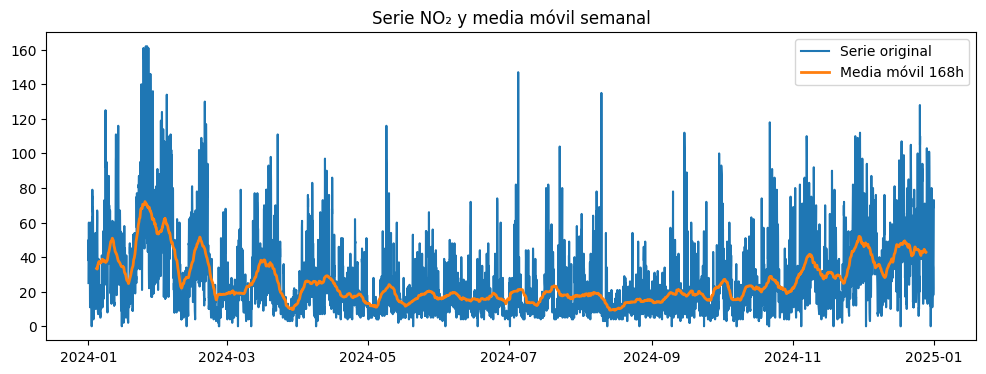

In [37]:
window = 24 * 7  # 1 semana de horas
rolling_mean = ts.rolling(window=window, center=True).mean()

plt.figure(figsize=(12,4))
plt.plot(ts,           label='Serie original')
plt.plot(rolling_mean, lw=2, label=f'Media móvil {window}h')
plt.title('Serie NO₂ y media móvil semanal')
plt.legend()
plt.show()

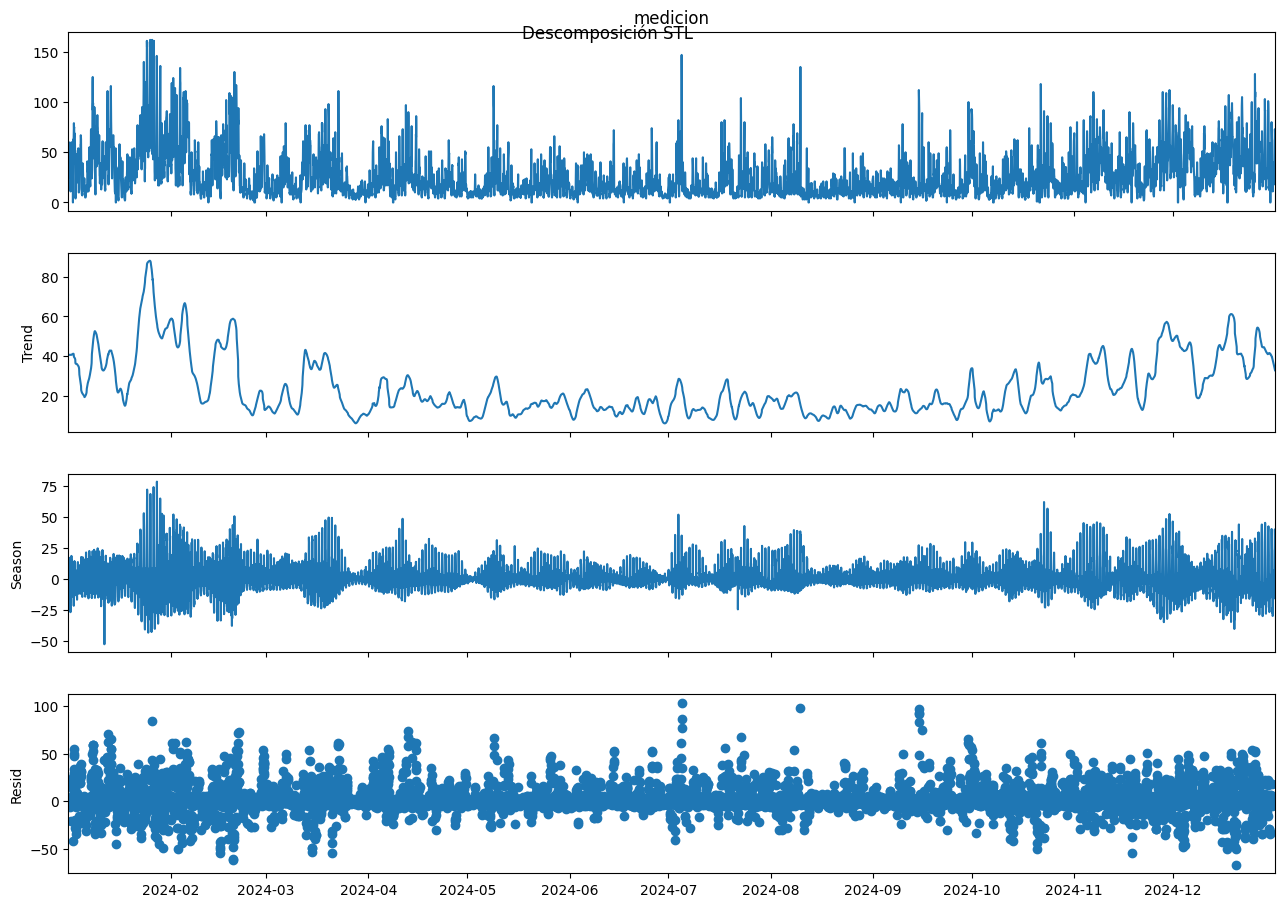

In [38]:
stl = STL(ts, period=24, robust=True)
res  = stl.fit()
fig = res.plot()
fig.set_size_inches(14,10)
plt.suptitle('Descomposición STL', y=0.93)
plt.show()

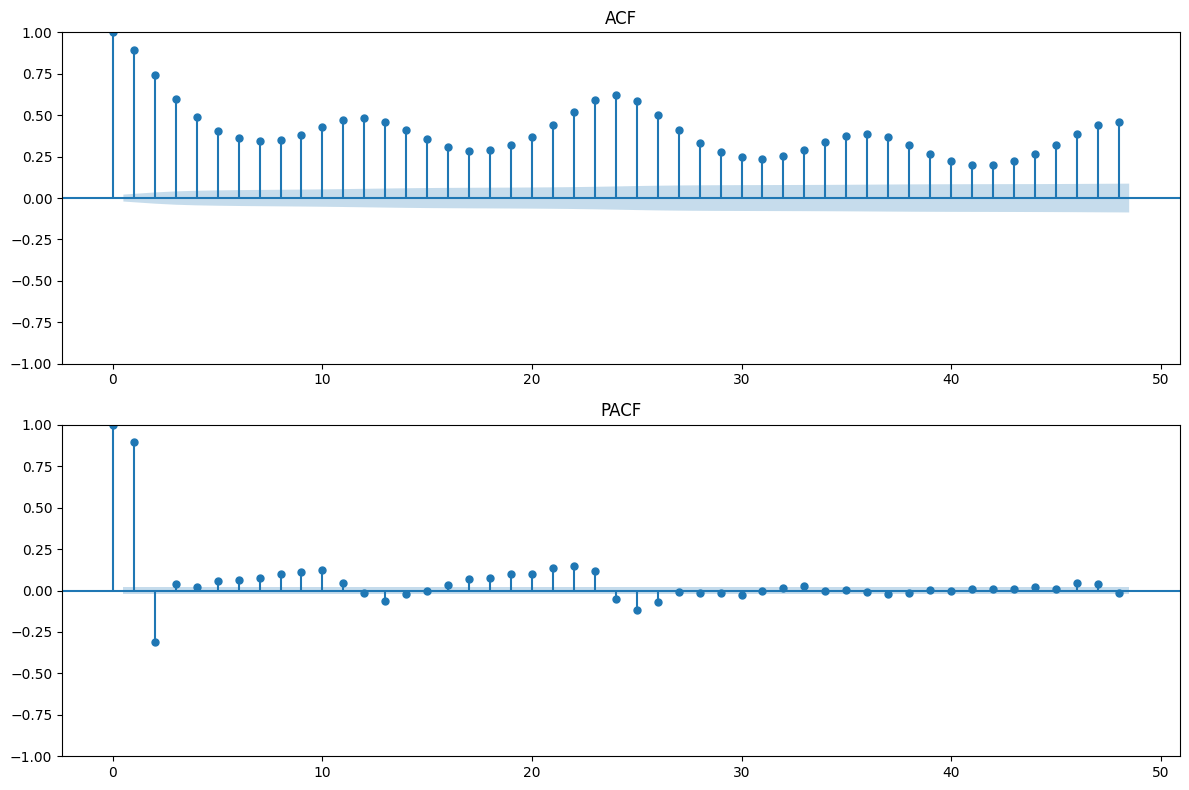

In [39]:
nlags = 48  # hasta 2 días
fig, axes = plt.subplots(2,1, figsize=(12,8))
plot_acf(ts,  lags=nlags, ax=axes[0])
axes[0].set_title('ACF')
plot_pacf(ts, lags=nlags, ax=axes[1], method='ywm')
axes[1].set_title('PACF')
plt.tight_layout()
plt.show()

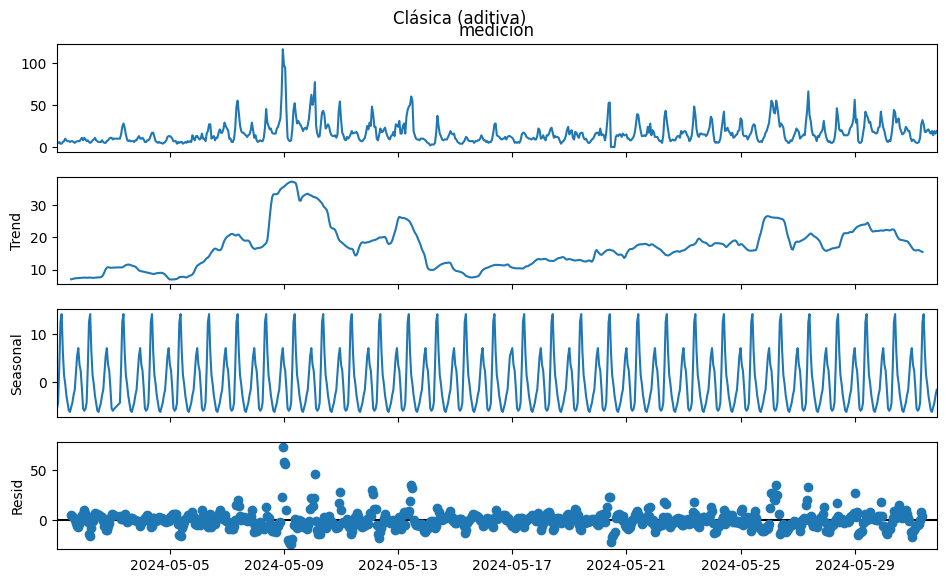

In [40]:
period = 24

decomp = seasonal_decompose(ts_week, model='additive', period=period)
fig = decomp.plot(); fig.set_size_inches(10,6); plt.suptitle('Clásica (aditiva)'); plt.show()

La descomposición STL revela que la serie de “medición” combina una clara tendencia estacional anual—con valores altos al inicio, un descenso a mitad de año y un repunte final—con ciclos diarios muy marcados (picos en horas punta y valles nocturnos). Además, la ACF se mantiene positiva incluso en el lag 24 (ciclo diario) y evidenciando así una fuerte persistencia y estacionalidad diaria.

# Modelos

In [41]:
serie_2024_completa['intensidad_trafico_1'].isna().sum(), serie_2024_completa['intensidad_trafico_1'].isna().sum()/len(serie_2024_completa)*100

(np.int64(673), np.float64(7.6634024140286945))

Tras observar que el campo 'intensidad_trafico_1' tiene un 7,66% de valores nulos, se decide eliminarlo del análisis.

In [42]:
serie_2024_completa.drop(columns=['intensidad_trafico_1'], inplace=True)

In [43]:
serie_2024_completa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8782 entries, 2024-01-01 01:00:00 to 2024-12-31 22:00:00
Freq: h
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CODIGO_CORTO          8740 non-null   float64
 1   medicion              8740 non-null   float64
 2   flag                  8740 non-null   object 
 3   intensidad_trafico_2  8740 non-null   float64
 4   intensidad_trafico_3  8736 non-null   float64
 5   intensidad_trafico_4  8738 non-null   float64
dtypes: float64(5), object(1)
memory usage: 480.3+ KB


Respecto al resto de campos con valores nulos, se opta por hacer un  Eforward-fill, es decir, cada hueco se rellena con el último valor no nulo observado justo antes de él. Esto es Útil para mantener la inercia de una medida cuando, por ejemplo, un sensor deja de reportar datos durante un intervalo corto.

In [44]:
serie_2024_completa.index = pd.to_datetime(serie_2024_completa.index)
serie_2024_completa = serie_2024_completa.sort_index().asfreq('H')  # ajusta freq si no es hora

# Forward‐fill para **todas** las columnas
serie_ffill = serie_2024_completa.fillna(method='ffill')

C:\Users\japegomez\AppData\Local\Temp\ipykernel_89656\776590705.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  serie_2024_completa = serie_2024_completa.sort_index().asfreq('H')  # ajusta freq si no es hora
C:\Users\japegomez\AppData\Local\Temp\ipykernel_89656\776590705.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie_ffill = serie_2024_completa.fillna(method='ffill')


In [45]:
serie_ffill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8782 entries, 2024-01-01 01:00:00 to 2024-12-31 22:00:00
Freq: h
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CODIGO_CORTO          8782 non-null   float64
 1   medicion              8782 non-null   float64
 2   flag                  8782 non-null   object 
 3   intensidad_trafico_2  8782 non-null   float64
 4   intensidad_trafico_3  8782 non-null   float64
 5   intensidad_trafico_4  8782 non-null   float64
dtypes: float64(5), object(1)
memory usage: 480.3+ KB


Antes de aplicar el modelo, se comprueba la estacionaridad de la serie temporal mediante la prueba de Dickey-Fuller aumentada (ADF). La hipótesis nula de esta prueba es que la serie tiene una raíz unitaria, lo que indica no estacionaridad. Si el valor p es menor que 0.05, se rechaza la hipótesis nula y se concluye que la serie es estacionaria.
En este caso, el valor p es 0.000, lo que indica que la serie es estacionaria y no requiere diferenciación adicional.

In [46]:
ts = serie_ffill['medicion'].copy()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('H')

# 2) Test de estacionariedad (ADF) ---------------------------------------
adf_stat, p_value, *_ = adfuller(ts)
print(f"p-value: {p_value:.3f}")
if p_value > 0.05:
    # no es estacionaria: diferenciamos
    ts_diff = ts.diff().dropna()
    title = "Serie 1ª diferencia"
else:
    ts_diff = ts
    title = "Serie original (ya estacionaria)"

C:\Users\japegomez\AppData\Local\Temp\ipykernel_89656\4285614737.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = ts.asfreq('H')


p-value: 0.000


## Modelo autorregresivo (AR)

MAE out-of-sample: 19.355


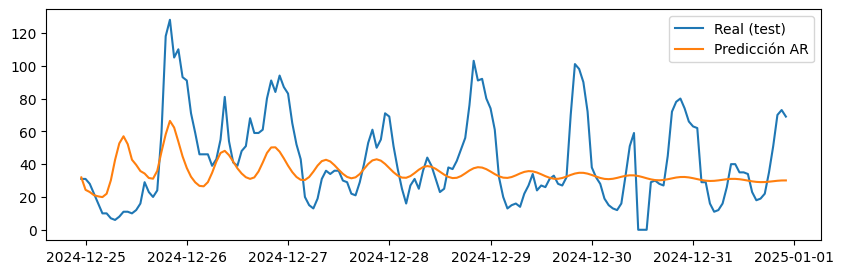

In [ ]:
n_test = 168 # 7 días (168h) de test
ts_diff_train = ts_diff.iloc[:-n_test]
ts_diff_test  = ts_diff.iloc[-n_test:]  

model_ar = AutoReg(ts_diff_train, lags=24, trend='n').fit()


start = ts_diff_train.index[-1]          # último instante de train
end   = ts_diff_test.index[-1]           # último instante de test
pred_diff = model_ar.predict(start=start, end=end)

pred_diff = pred_diff.iloc[1:]


pred_ar = pred_diff

y_true = ts.loc[ts_diff_test.index]
mae = mean_absolute_error(y_true, pred_ar)
print(f'MAE out-of-sample: {mae:.3f}')

# Gráfica real vs predicción
plt.figure(figsize=(10,3))
plt.plot(y_true, label='Real (test)')
plt.plot(pred_ar,   label='Predicción AR')
plt.legend()
plt.show()

## Modelo SARIMAX

C:\Users\japegomez\AppData\Local\Temp\ipykernel_89656\2764629510.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  serie = serie.asfreq('H')  # frecuencia horaria
C:\Users\japegomez\AppData\Local\Temp\ipykernel_89656\2764629510.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = serie[['intensidad_trafico_2',
c:\Users\japegomez\miniconda3\envs\ciudades\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE SARIMAX exógeno: 15.623


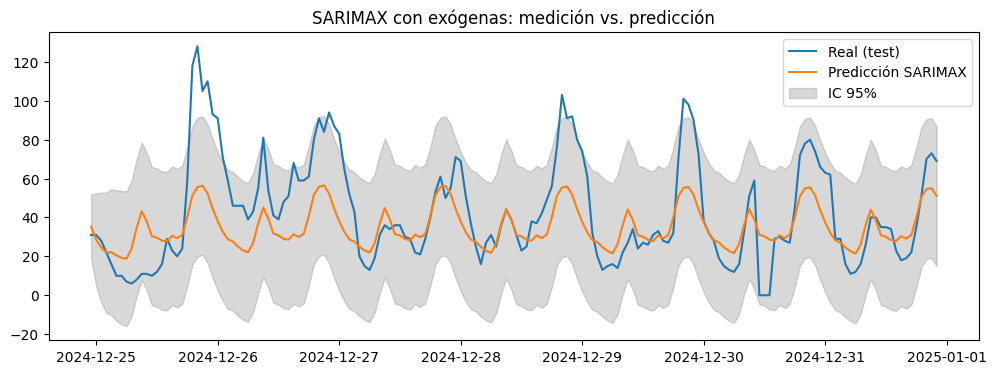

In [48]:
serie = serie_ffill.copy()
serie.index = pd.to_datetime(serie.index)
serie = serie.asfreq('H')  # frecuencia horaria

# endógena: medición
y = serie['medicion']

# exógenas: intensidades de tráfico 2,3,4
X = serie[['intensidad_trafico_2',
           'intensidad_trafico_3',
           'intensidad_trafico_4']].fillna(method='ffill')

# Train/Test split 
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]

# Orden no estacional (p,d,q)
p, d, q = 2, 0, 0
# Orden estacional (P,D,Q,s), aquí s=24 para ciclo diario
P, D, Q, s = 1, 0, 1, 24

model = SARIMAX(
    endog        = y_train,
    exog         = X_train,
    order        = (p,d,q),
    seasonal_order=(P,D,Q,s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

fc = res.get_forecast(steps=n_test, exog=X_test)
y_pred_sarimax = fc.predicted_mean
ci    = fc.conf_int()

mae = mean_absolute_error(y_test, y_pred_sarimax)
print(f'MAE SARIMAX exógeno: {mae:.3f}')

# Gráfica real vs predicción 
plt.figure(figsize=(12,4))
plt.plot(y_test,   label='Real (test)')
plt.plot(y_pred_sarimax,   label='Predicción SARIMAX')
plt.fill_between(ci.index,
                 ci.iloc[:,0],
                 ci.iloc[:,1],
                 color='gray', alpha=0.3,
                 label='IC 95%')
plt.legend()
plt.title('SARIMAX con exógenas: medición vs. predicción')
plt.show()


# Modelo de regresión lineal

CV MAE: 16.756 ± 3.670
Test MAE: 23.001


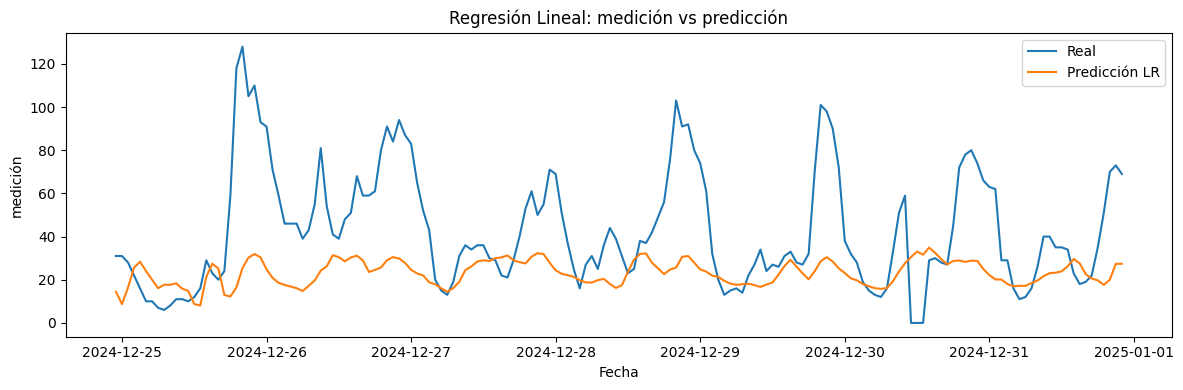

In [49]:
df = serie_ffill.copy()

# crear lags 1,2,3h para cada intensidad
for col in ['intensidad_trafico_2','intensidad_trafico_3','intensidad_trafico_4']:
    for lag in [1,2,3]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# descartamos filas con NaN (por los lags)
df = df.dropna()

# definimos X e y
feature_cols = [
    'intensidad_trafico_2','intensidad_trafico_3','intensidad_trafico_4',
    'intensidad_trafico_2_lag1','intensidad_trafico_2_lag2','intensidad_trafico_2_lag3',
    'intensidad_trafico_3_lag1','intensidad_trafico_3_lag2','intensidad_trafico_3_lag3',
    'intensidad_trafico_4_lag1','intensidad_trafico_4_lag2','intensidad_trafico_4_lag3'
]
X = df[feature_cols]
y = df['medicion']

X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

# Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# Validación cruzada temporal (CV)
tscv = TimeSeriesSplit(n_splits=5)
cv_maes = []
for train_idx, val_idx in tscv.split(X_train):
    pipe.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_val_pred = pipe.predict(X_train.iloc[val_idx])
    cv_maes.append(mean_absolute_error(y_train.iloc[val_idx], y_val_pred))

print(f"CV MAE: {np.mean(cv_maes):.3f} ± {np.std(cv_maes):.3f}")

# Entrenar en todo el train y evalúa en test 
pipe.fit(X_train, y_train)
y_pred_lr = pipe.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_lr)
print(f"Test MAE: {test_mae:.3f}")

# Gráfica real vs predicción 
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test,    label='Real')
plt.plot(y_test.index, y_pred_lr,    label='Predicción LR')
plt.title('Regresión Lineal: medición vs predicción')
plt.xlabel('Fecha')
plt.ylabel('medición')
plt.legend()
plt.tight_layout()
plt.show()


## Modelo con Random Forest

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\japegomez\miniconda3\envs\ciudades\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\japegomez\miniconda3\envs\ciudades\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\japegomez\miniconda3\envs\ciudades\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\japegomez\miniconda3\envs\ciudades\lib\site-packages\sklearn\pipeline.py", line 662, in fit
   

Mejores parámetros: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
MEAN CV MAE: 16.33838999328692
Test MAE: 24.118


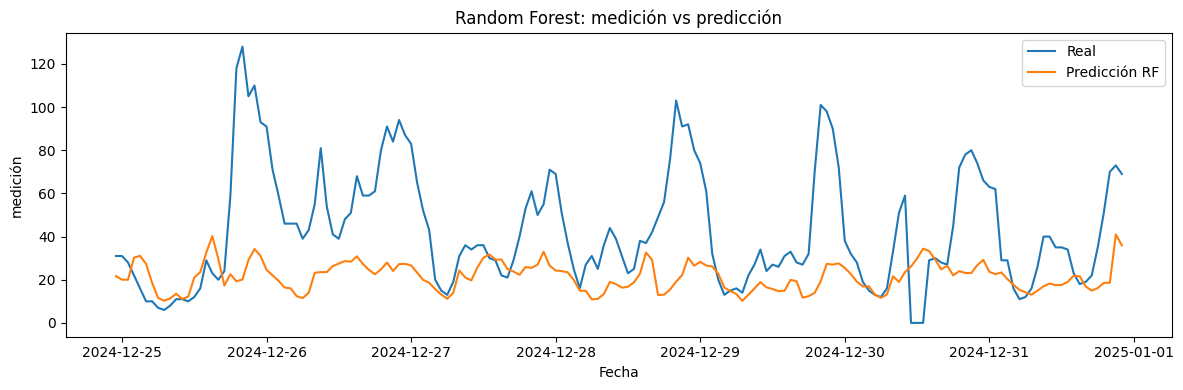

In [50]:
df = serie_ffill.copy()

for col in ['intensidad_trafico_2','intensidad_trafico_3','intensidad_trafico_4']:
    for lag in [1,2,3]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

df = df.dropna()

feature_cols = [
    'intensidad_trafico_2','intensidad_trafico_3','intensidad_trafico_4',
    'intensidad_trafico_2_lag1','intensidad_trafico_2_lag2','intensidad_trafico_2_lag3',
    'intensidad_trafico_3_lag1','intensidad_trafico_3_lag2','intensidad_trafico_3_lag3',
    'intensidad_trafico_4_lag1','intensidad_trafico_4_lag2','intensidad_trafico_4_lag3'
]
X = df[feature_cols]
y = df['medicion']

n_test = 24 * 7  # última semana como test
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

# Pipeline y Grid Search 
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),          # opcional para RF
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 200, 500],
    'rf__max_depth': [None, 10, 20],
    'rf__max_features': ['auto','sqrt']
}

tscv = TimeSeriesSplit(n_splits=5)

gsearch = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

gsearch.fit(X_train, y_train)

print("Mejores parámetros:", gsearch.best_params_)
print("MEAN CV MAE:", -gsearch.best_score_)

# Evaluación en test
best_rf = gsearch.best_estimator_
y_pred_rf = best_rf.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Test MAE: {test_mae:.3f}")

# Gráfica real vs predicción 
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test,    label='Real')
plt.plot(y_test.index, y_pred_rf,    label='Predicción RF')
plt.title('Random Forest: medición vs predicción')
plt.xlabel('Fecha')
plt.ylabel('medición')
plt.legend()
plt.tight_layout()
plt.show()


## Modelo con redes neuronales

c:\Users\japegomez\miniconda3\envs\ciudades\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 771.4794 - mae: 19.1629 - val_loss: 837.4058 - val_mae: 22.0424
Epoch 2/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 430.9839 - mae: 14.3510 - val_loss: 745.3498 - val_mae: 20.7089
Epoch 3/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 415.4439 - mae: 14.0510 - val_loss: 744.2150 - val_mae: 20.6716
Epoch 4/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 413.1290 - mae: 13.9824 - val_loss: 720.0765 - val_mae: 20.2976
Epoch 5/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 411.8291 - mae: 14.0506 - val_loss: 751.5992 - val_mae: 20.6804
Epoch 6/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 396.3735 - mae: 13.7829 - val_loss: 734.4228 - val_mae: 20.4540
Epoch 7/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 371.4593 - mae: 13.4069 - val_loss: 746.9792 - val_mae: 20.6265
Epoch 8/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 396.8884 - mae: 13.7450 - val_loss: 728.7466 - val_mae: 20.4510


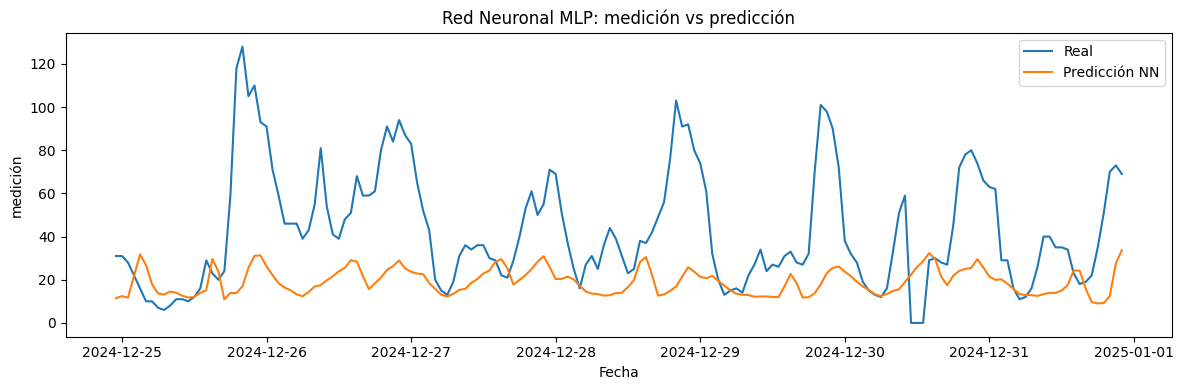

In [51]:
df = serie_ffill.copy()

for col in ['intensidad_trafico_2','intensidad_trafico_3','intensidad_trafico_4']:
    for lag in [1,2,3]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

df = df.dropna()

feature_cols = [
    'intensidad_trafico_2','intensidad_trafico_3','intensidad_trafico_4',
    'intensidad_trafico_2_lag1','intensidad_trafico_2_lag2','intensidad_trafico_2_lag3',
    'intensidad_trafico_3_lag1','intensidad_trafico_3_lag2','intensidad_trafico_3_lag3',
    'intensidad_trafico_4_lag1','intensidad_trafico_4_lag2','intensidad_trafico_4_lag3'
]
X = df[feature_cols].values
y = df['medicion'].values

n_test = 24 * 7  # última semana como test
X_train, X_test = X[:-n_test], X[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Entrenamiento con EarlyStopping
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

mse, mae_nn = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MAE en test (NN): {mae_nn:.3f}")

y_pred_nn = model.predict(X_test_scaled).flatten()

plt.figure(figsize=(12,4))
plt.plot(df.index[-n_test:], y_test,    label='Real')
plt.plot(df.index[-n_test:], y_pred_nn, label='Predicción NN')
plt.title('Red Neuronal MLP: medición vs predicción')
plt.xlabel('Fecha')
plt.ylabel('medición')
plt.legend()
plt.tight_layout()
plt.show()


# Dashboard

In [56]:
# Parámetros
window = 24 * 7
nlags  = 48

# Media móvil
rolling_mean = ts.rolling(window=window, center=True).mean()

# Fig 1: Serie vs Media móvil
fig_rolling = go.Figure()
fig_rolling.add_trace(go.Scatter(x=ts.index, y=ts, mode='lines', name='Serie original'))
fig_rolling.add_trace(go.Scatter(x=rolling_mean.index, y=rolling_mean, mode='lines', name=f'Media móvil {window}h'))
fig_rolling.update_layout(title='Serie NO₂ y Media Móvil Semanal',
                          xaxis_title='Fecha', yaxis_title='Medición')

# ACF / PACF
acf_vals  = acf(ts, nlags=nlags)
pacf_vals = pacf(ts, nlags=nlags, method='ywm')
lags = list(range(len(acf_vals)))

# Fig 2: ACF y PACF
fig_acf_pacf = make_subplots(rows=2, cols=1, subplot_titles=('ACF','PACF'))
fig_acf_pacf.add_trace(go.Bar(x=lags, y=acf_vals), row=1, col=1)
fig_acf_pacf.add_trace(go.Bar(x=lags, y=pacf_vals), row=2, col=1)
fig_acf_pacf.update_layout(height=800, title='ACF y PACF', showlegend=False)

# Fig 3: Predicciones vs reales
fig_preds = go.Figure()
fig_preds.add_trace(go.Scatter(x=y_true.index, y=y_true, mode='lines', name='Reales'))
fig_preds.add_trace(go.Scatter(x=y_true.index, y=pred_ar, mode='lines', name='AR (MAE=19.355)'))
fig_preds.add_trace(go.Scatter(x=y_true.index, y=y_pred_sarimax, mode='lines', name='SARIMAX (MAE=15.623)'))
fig_preds.add_trace(go.Scatter(x=y_true.index, y=y_pred_lr, mode='lines', name='LinReg (MAE=23.001)'))
fig_preds.add_trace(go.Scatter(x=y_true.index, y=y_pred_rf, mode='lines', name='RF (MAE=24.118)'))
fig_preds.add_trace(go.Scatter(x=y_true.index, y=y_pred_nn, mode='lines', name='NN (MAE=25.135)'))
fig_preds.update_layout(title='Predicciones vs Valores Reales',
                        xaxis_title='Fecha', yaxis_title='Medición')

# Fig 4: Comparativa MAE
model_names = ['AR','SARIMAX','LinReg','RF','NN']
mae_values  = [19.355, 15.623, 23.001, 24.118, 25.135]
fig_mae = go.Figure([go.Bar(x=model_names, y=mae_values)])
fig_mae.update_layout(title='MAE por Modelo',
                      xaxis_title='Modelo', yaxis_title='MAE')


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'type': 'bar', 'x': ['AR', 'SARIMAX', 'LinReg', 'RF', 'NN'], 'y': [19.355, 15.623, 23.001, 24.118, 25.135]}],
    'layout': {'template': '...',
               'title': {'text': 'MAE por Modelo'},
               'xaxis': {'title': {'text': 'Modelo'}},
               'yaxis': {'title': {'text': 'MAE'}}}
})

In [55]:
app = dash.Dash(__name__)
app.layout = html.Div([
    dcc.Tabs([
        # Pestaña 1: Análisis de la serie
        dcc.Tab(label='Análisis serie temporal', children=[
            # Gráfico 1: Serie vs Media Móvil
            dcc.Graph(figure=fig_rolling),

            # Gráfico 2: ACF y PACF
            dcc.Graph(figure=fig_acf_pacf),

            # Texto descriptivo tras el ACF/PACF
            html.Div([
                html.P(
                    "El análisis de la serie temporal revela que la serie de “medición” combina "
                    "una clara tendencia estacional anual—con valores altos al inicio, un descenso "
                    "a mitad de año y un repunte final—con ciclos diarios muy marcados "
                    "(picos en horas punta y valles nocturnos). Además, la ACF se mantiene positiva "
                    "incluso en el lag 24 (ciclo diario), evidenciando así una fuerte persistencia "
                    "y estacionalidad diaria."
                )
            ], style={'margin': '20px 0', 'backgroundColor': '#f9f9f9', 'padding': '10px'})
        ]),

        # Pestaña 2: Comparación de modelos y conclusiones
        dcc.Tab(label='Comparación modelos', children=[
            # Gráfico 3: Predicciones vs Valores Reales
            dcc.Graph(figure=fig_preds),

            # Gráfico 4: Comparativa de MAE
            dcc.Graph(figure=fig_mae),

            # Texto de conclusiones al final
            html.Div([
                html.H4("Conclusiones"),
                html.P(
                    "De los modelos probados, SARIMAX obtuvo el menor MAE (15.623), superando al "
                    "modelo autorregresivo, la regresión lineal, Random Forest y la red neuronal. Esto "
                    "indica que incorporar las intensidades de tráfico como variables exógenas mejora "
                    "significativamente la predicción de la medición."
                )
            ], style={'margin': '20px 0', 'backgroundColor': '#f9f9f9', 'padding': '10px'})
        ])
    ])
])

if __name__ == '__main__':
    app.run(debug=True)
